In [1]:
oil_data <- read.table(file="./oilspills.dat", header=TRUE)

 head(oil_data)

,year,spills,importexport,domestic
,<int>,<int>,<dbl>,<dbl>
1,1974,2,0.720,0.22
2,1975,5,0.850,0.17
3,1976,3,1.120,0.15
4,1977,3,1.345,0.20
5,1978,1,1.290,0.59
6,1979,5,1.260,0.64


In [2]:
x <- cbind(oil_data$importexport, oil_data$domestic)
y <- oil_data$spills

In [3]:
poisson_prob <- function(x, y, params) {
    lambda <- x %*% params

    (lambda^y)*exp(-lambda) / factorial(y)
}

In [4]:
loglikelihood_func <- function(x, y, params) {
    lambda <- x %*% params
    log_vals  <- y*log(lambda) - lambda - log(factorial(y))

    sum(log_vals)
}

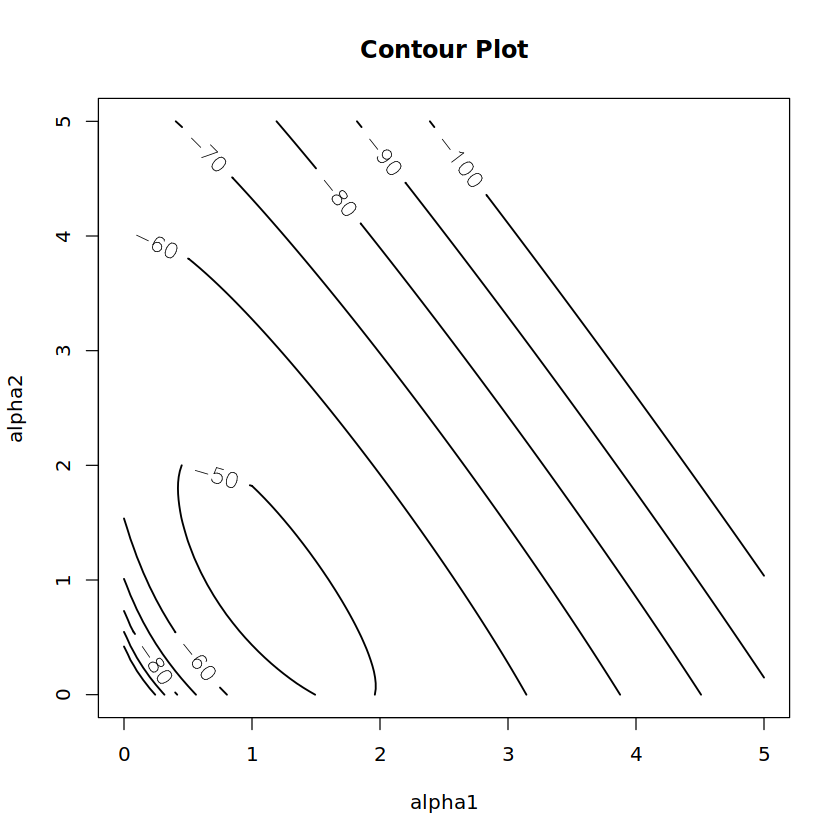

In [5]:
alpha1_seq <- seq(0., 5., by=0.05)
alpha2_seq <- seq(0., 5., by=0.05)

 z <- matrix(0, nrow = length(alpha1_seq), ncol = length(alpha2_seq))
 for(i in 1:length(alpha1_seq)) {
     for(j in 1:length(alpha2_seq)) {
        z[i, j] <- loglikelihood_func(x, y, c(alpha1_seq[i], alpha2_seq[j]))
     }
}

contour(
    alpha1_seq, alpha2_seq, z,
    main = "Contour Plot",
    levels =  c(seq(-100, 0, by = 10)),
    lwd = 1.5,
    xlab = "alpha1",
    ylab = "alpha2",
    labcex = 1.2
)

In [6]:
plot_optimal_point <- function(optimal_point, plot_name) {
    contour(
        alpha1_seq, alpha2_seq, z,
        levels =  c(seq(-100, 0, by = 10)),
        lwd = 1.5,
        xlab = "alpha1",
        ylab = "alpha2",
        labcex = 1.2
    )
    title(main=paste(strwrap(plot_name, width=60), collapse="\n"))
    points(
        x=optimal_point[1], y=optimal_point[2],
        pch = 16, type = "b", col="red", cex = 1.5)
}

In [7]:
grad_func <- function(x, y, params) {
    n <- dim(x)[1]
    lambda <- x %*% params
    val <- sum(y / lambda) - n

    val * params
}

In [8]:
second_grad_func <- function(x, y, params) {
    n <- dim(x)[1]
    lambda <- x %*% params
    t <- -y/(lambda^2)
    grad_11 <- sum((x[,1]^2)*t) - n
    grad_12 <- sum((x[,1]*x[,2])*t)
    grad_22 <- sum((x[,2]^2)*t) - n 

    matrix(c(grad_11, grad_12, grad_12, grad_22), nrow=2, byrow=TRUE)
}

### Naive Newton method

In [9]:
newton_updating <- function(x, y, params) {
    grad <- grad_func(x, y, params)
    hess <- second_grad_func(x, y, params)
    d <- -solve(hess, grad)
    
    params <- params + d
}

newton_optimizer <- function(x, y, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        params <- newton_updating(x, y, old_params)

        err <- norm(params - old_params, type="2")
        if (err <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

Interations: 1, initial points: (1.00, 1.00) optimal points: (1.0661, 1.0922)

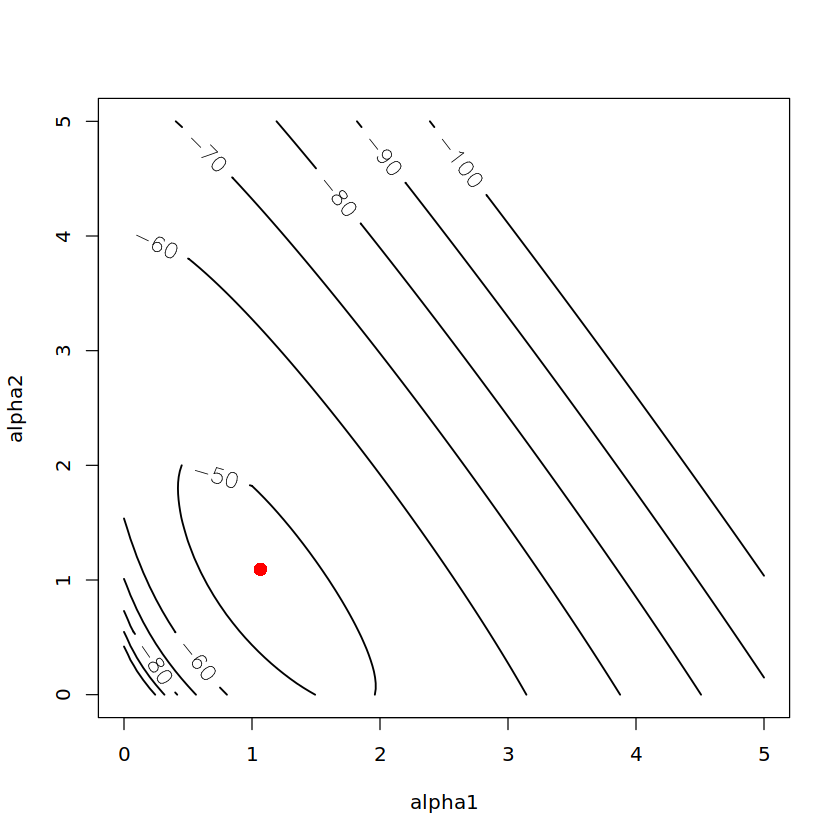

In [10]:
max_iter <- 1
threshold <- 1e-5

init_params <- c(1., 1.)

result <- newton_optimizer(x, y, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

### Newton method with fisher scoring matrix

Fisher scoring matrix: $\mathbb{X}^{T}\mathbb{W}\mathbb{X}$ with $\mathbb{W} = diag(1 /\lambda_1,..., 1/\lambda_p)$

In [11]:
fisher_matrix <- function(x, params) {
    lambda <- x %*% params
    w <- c(1 / lambda)
    w <- diag(w, length(w), length(w))

    t(x) %*% w %*% x
}

In [12]:
newtonlike_updating <- function(params, M, grad, a=1) {
    d <- -solve(M, grad)
    
    params <- params + a*d
}

newton_optimizer <- function(x, y, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        grad <- grad_func(x, y, old_params)
        M <- -fisher_matrix(x, old_params)
        params <- newtonlike_updating(old_params, M, grad)

        err <- norm(params - old_params, type="2")
        if (err <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

Interations: 2, initial points: (1.00, 1.00) optimal points: (0.7571, 1.8798)

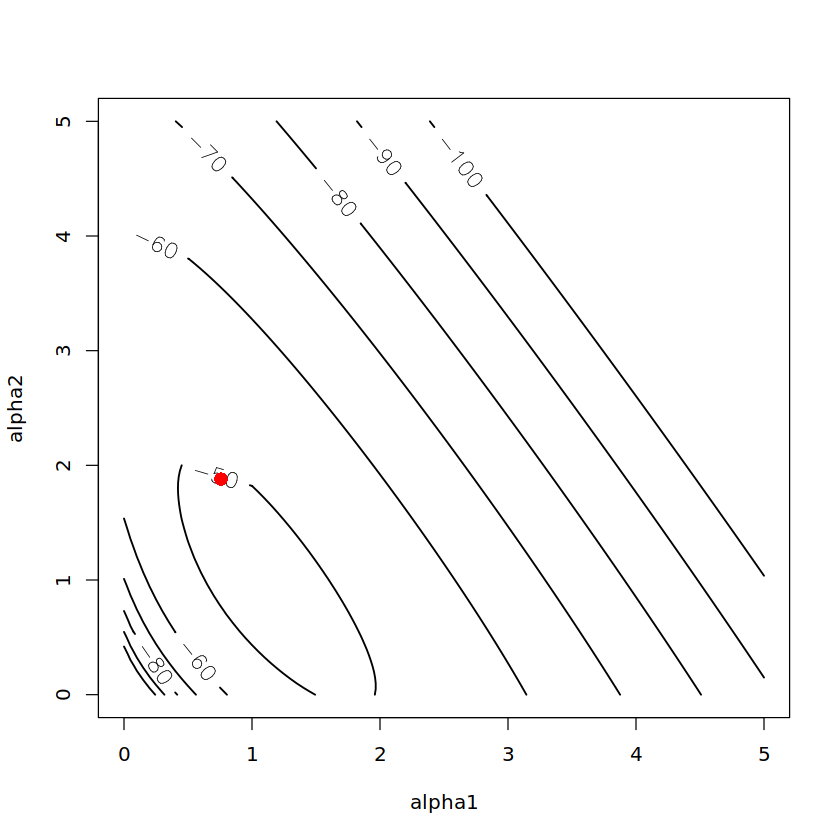

In [19]:
max_iter <- 2
threshold <- 1e-5

init_params <- c(1., 1.)

result <- newton_optimizer(x, y, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)